In [1]:
import logging
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchvision
from torchviz import make_dot

sys.path.append("..")
from config import get_config, default_config
from inference import predict_spectral
from models import SpectralNet, ChromaNet
from builders import build_chroma_net, build_spectral_net, build_dataloader, build_spectral_model
from jpegutils import JPEGTransforms, SUBSAMPLE_FACTORS
from dataset import ToDCTTensor, ToQTTensor
from utils import load_checkpoint

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
current_dir = os.getcwd()
os.chdir("..")

In [4]:
config = default_config()
config.defrost()
config.TRAIN.DEVICE = "cpu"
config.DATA.PATCH_SIZE = 128
config.DATA.LOCATIONS.TEST = "data/Live1-Classic5/live1/refimgs"
config.TEST.BATCH_SIZE = 1
config.DATA.NUM_PATCHES = 1
config.DATA.USE_HQ_DCT = True
config.DATA.USE_HQ_YCC = True
config.DATA.USE_Q_RGB = True
config.DATA.USE_LQ_YCC = True
config.MODEL.SPECTRAL.DEPTH = 2
config.MODEL.SPECTRAL.EMBED_DIM = 128
config.MODEL.SPECTRAL.NUM_HEADS = [4,4]

# spectral_net = build_spectral_net(config)
# chroma_net = build_chroma_net(config)
spectral_model = build_spectral_model(config)
# dataloader = build_dataloader(config, "test")

In [5]:
# activation = {}

# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# def get_input(name):
#     def hook(model, input, output):
#         activation[name] = input[0].detach()
#     return hook

# spectral_net.output_transform.register_forward_hook(get_input('idct_input'))

In [6]:
# os.makedirs("data/overfit/", exist_ok=True)
# touint8 = torchvision.transforms.ConvertImageDtype(torch.uint8)

# for datapoint in dataloader:
#     name = os.path.basename(datapoint["filepath"][0])
#     name = '.'.join(name.split('.')[:-1])
#     savepath = os.path.join("data/overfit", name + ".png")
#     img = touint8(datapoint["hq_rgb"][0])
#     torchvision.io.write_png(img, savepath)

In [7]:
# datapoint = next(iter(dataloader))

In [8]:
# torch.save(datapoint, "sample_datapoint.pth")

In [9]:
datapoint = torch.load("sample_datapoint.pth")
None

/var/folders/89/b5lh60hs3x1g1db4v2dx04980000gn/T/ipykernel_74095/458368354.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datapoint = torch.load("sample_datapoint.pth")

In [10]:
img = datapoint["hq_rgb"][0].permute(1,2,0).numpy()

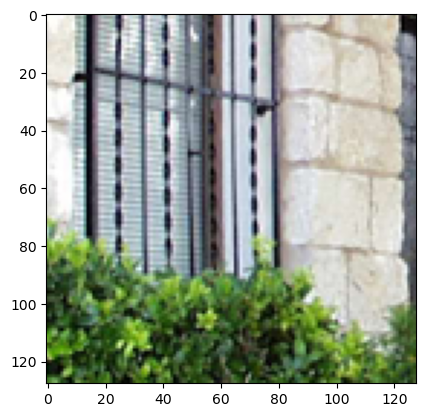

In [11]:
plt.imshow(img)

In [ ]:
batch = 

In [13]:
res = predict_spectral(spectral_model, spectral_model, datapoint, "identity", 420)

In [10]:
params_mean, params_std = {}, {}

for name, param in spectral_model.named_parameters():
    params_mean[name] = param.data.mean()
    params_std[name]  = param.data.std()

In [11]:
params_std

{'block_encoder.project.weight': tensor(0.0712),
 'block_encoder.project.bias': tensor(0.0694),
 'transformer.encoders.0.local_attention.relative_positional_bias': tensor(0.),
 'transformer.encoders.0.local_attention.project_q.weight': tensor(0.0014),
 'transformer.encoders.0.local_attention.project_q.bias': tensor(0.0504),
 'transformer.encoders.0.local_attention.project_k.weight': tensor(0.0014),
 'transformer.encoders.0.local_attention.project_k.bias': tensor(0.0494),
 'transformer.encoders.0.local_attention.project_v.weight': tensor(0.0014),
 'transformer.encoders.0.local_attention.project_v.bias': tensor(0.0539),
 'transformer.encoders.0.layernorm1.weight': tensor(0.),
 'transformer.encoders.0.layernorm1.bias': tensor(0.),
 'transformer.encoders.0.layernorm2.weight': tensor(0.),
 'transformer.encoders.0.layernorm2.bias': tensor(0.),
 'transformer.encoders.0.feedforward.0.weight': tensor(0.0510),
 'transformer.encoders.0.feedforward.0.bias': tensor(0.0500),
 'transformer.encoders.0

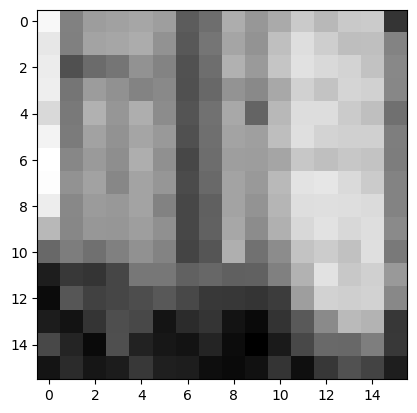

In [22]:
x = res["dctY"][0].reshape(8,8,16,16)[0,0,:,:].detach().numpy()
plt.imshow(x, cmap="gray")

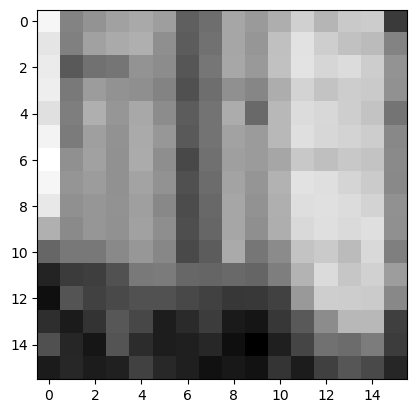

In [24]:
plt.imshow(datapoint["hq_dct_y"][0].reshape(8,8,16,16)[0,0,:,:].detach().numpy(), cmap="gray")

In [9]:
spectral_net = build_spectral_net(config)

In [15]:
with torch.no_grad():
    spectral_net.blocks[0].encoders[0].local_attention.relative_positional_bias.data = 10 * eye
# spectral_net.blocks[0].encoders[0].local_attention.relative_positional_bias.data = eye


In [16]:
NORMAL_STD = 0.2

def init_param(module_):
    if isinstance(module_, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module_.weight, gain=NORMAL_STD)
    # if isinstance(module_, torch.nn.Conv2d):
        # torch.nn.init.xavier_uniform_(module_.weight, gain=NORMAL_STD)
    # if isinstance(module_, torch.nn.Bilinear):
        # torch.nn.init.xavier_normal_(module_.weight, gain=NORMAL_STD)

In [17]:
spectral_net.apply(init_param)
None

In [28]:
spectral_net.zero_grad()
y = spectral_net(datapoint["hq_dct_y"], datapoint["qt_y"], chroma=False)
cb = spectral_net(datapoint["hq_dct_cb"], datapoint["qt_c"], chroma=True)
cr = spectral_net(datapoint["hq_dct_cr"], datapoint["qt_c"], chroma=True)

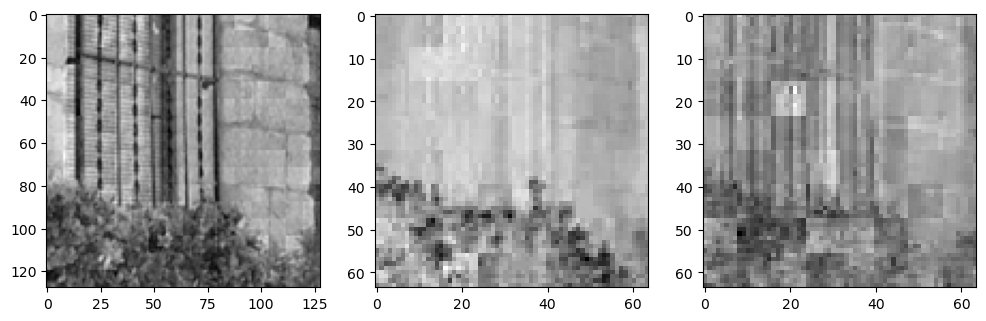

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(y.detach()[0,0].numpy(), cmap="gray")
axs[1].imshow(cb.detach()[0,0].numpy(), cmap="gray")
axs[2].imshow(cr.detach()[0,0].numpy(), cmap="gray")

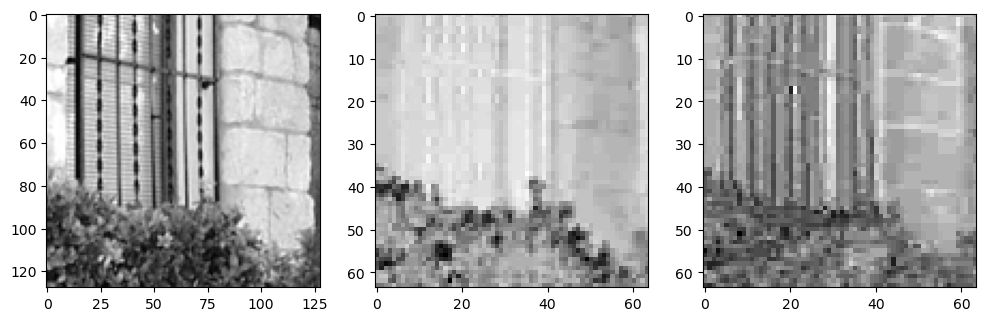

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(datapoint["hq_y"][0,0].numpy(), cmap="gray")
axs[1].imshow(datapoint["hq_cb"][0,0].numpy(), cmap="gray")
axs[2].imshow(datapoint["hq_cr"][0,0].numpy(), cmap="gray")

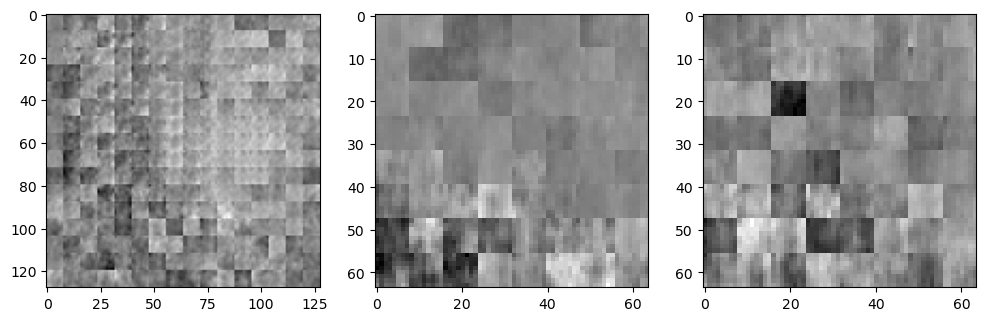

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(datapoint["hq_y"][0,0].numpy() - y.detach()[0,0].numpy(), cmap="gray")
axs[1].imshow(datapoint["hq_cb"][0,0].numpy() - cb.detach()[0,0].numpy(), cmap="gray")
axs[2].imshow(datapoint["hq_cr"][0,0].numpy() - cr.detach()[0,0].numpy(), cmap="gray")

In [25]:
criterion = torch.nn.MSELoss(reduction="mean")

In [32]:
loss = criterion(y, datapoint["hq_y"])# + criterion(cb, datapoint["hq_cb"]) + criterion(cr, datapoint["hq_cr"])
loss

tensor(0.0086, grad_fn=<MseLossBackward0>)

In [16]:
loss.backward()

In [38]:
graph = make_dot(loss, params=dict(spectral_net.named_parameters()), show_attrs=True, show_saved=True)

In [40]:
graph.render("SpectralNet.backward.graph")

'SpectralNet.backward.graph.pdf'

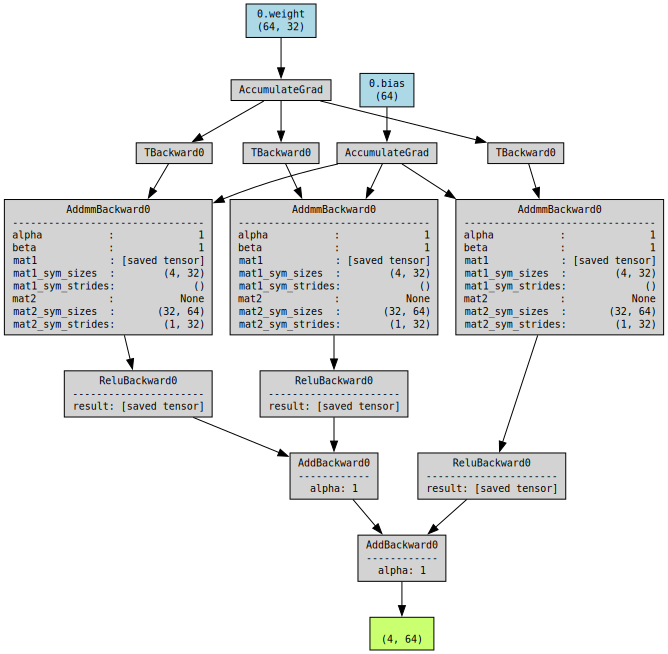

In [12]:
f = torch.nn.Sequential(torch.nn.Linear(32, 64), torch.nn.ReLU())
x, y, z = torch.randn(3, 4, 32)
a = f(x)
b = f(y)
c = f(z)
graph = make_dot(a + b + c, params=dict(f.named_parameters()), show_attrs=True)
graph

In [ ]:
grad_norm = {}

for name, param in spectral_net.named_parameters():
    if param.grad is None:
        print(name)
    else:
        grad_norm[name] = torch.linalg.norm(param.grad)

### Chroma Net

In [14]:
config.MODEL.CHROMA

CfgNode({'SKIP': False, 'DEPTHS': [1, 2, 1], 'CHANNELS': [32, 64, 32], 'CHANNEL_MULTIPLIER': 2, 'IN_CHANNELS': 3, 'OUT_CHANNELS': 3, 'STEM_KERNEL_SIZE': 3, 'BODY_KERNEL_SIZE': 3, 'LEAF_KERNEL_SIZE': 3})

In [8]:
chroma_net

ChromaNet(
  (output_transform): ConvertYccToRGB()
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): ConvNeXtBlock(
      (dwconv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pwconv1): Linear(in_features=32, out_features=64, bias=True)
      (activation): GELU(approximate='none')
      (pwconv2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): ModuleList(
    (0): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
)

In [9]:
datapoint["hq_rgb"].shape

torch.Size([1, 3, 128, 128])

In [10]:
rgb = chroma_net(datapoint["hq_rgb"])

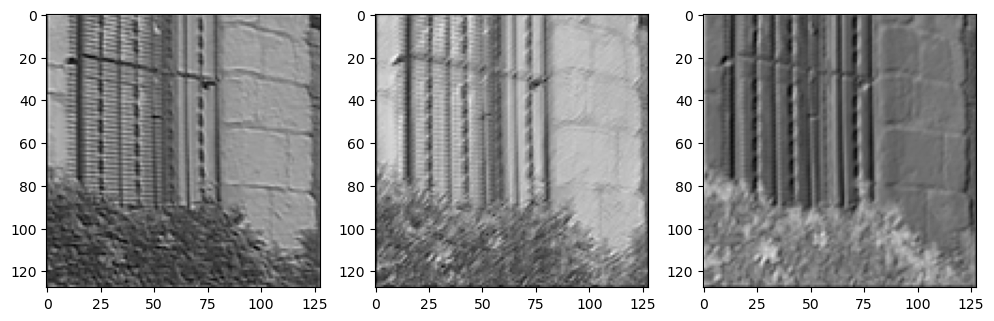

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(rgb.detach()[0,0].numpy(), cmap="gray")
axs[1].imshow(rgb.detach()[0,1].numpy(), cmap="gray")
axs[2].imshow(rgb.detach()[0,2].numpy(), cmap="gray")

In [13]:
rgb[0,0]

tensor([[ 0.1305,  2.1900,  0.3348,  ...,  1.3649,  0.9397,  0.5826],
        [ 0.1542,  0.2505, -0.3793,  ..., -0.2294,  1.0706,  0.6062],
        [-0.5393,  1.5968,  1.5802,  ..., -0.1326, -0.2558, -0.4936],
        ...,
        [ 0.7440, -0.0584, -0.2867,  ...,  0.4463,  0.4249,  1.3841],
        [ 1.2695,  1.1961,  1.1037,  ...,  1.5222,  0.9991,  0.5117],
        [ 2.2673,  2.6164,  3.0486,  ...,  1.3562,  0.3989,  1.4894]],
       grad_fn=<SelectBackward0>)

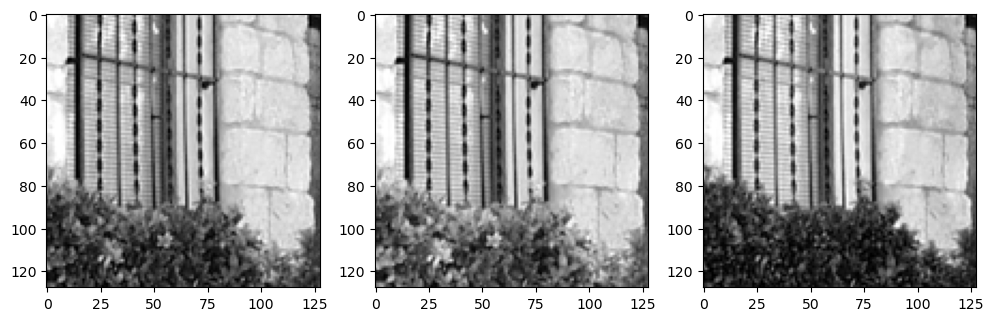

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(datapoint["hq_rgb"][0,0].numpy(), cmap="gray")
axs[1].imshow(datapoint["hq_rgb"][0,1].numpy(), cmap="gray")
axs[2].imshow(datapoint["hq_rgb"][0,2].numpy(), cmap="gray")